<a href="https://colab.research.google.com/github/Shadabur-Rahaman/30-days-ml-projects/blob/main/Day_24_autoencoder_denoising/notebooks/Day_24_autoencoder_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders for Image Denoising
## Day 24/30 of Machine Learning Project

**Project Goal**: Build an autoencoder neural network to remove noise from images using the MNIST dataset.

## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## 2. Load and Preprocess the Data

In [2]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and reshape
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f"Training shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training shape: (60000, 28, 28, 1)
Test shape: (10000, 28, 28, 1)


## 3. Add Noise to Images

In [3]:
# Function to add Gaussian noise
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    # Clip values to be between 0 and 1
    noisy = np.clip(noisy, 0., 1.)
    return noisy

# Create noisy datasets
noise_factor = 0.4
x_train_noisy = add_noise(x_train, noise_factor)
x_test_noisy = add_noise(x_test, noise_factor)

print("Noisy datasets created.")

Noisy datasets created.


## 4. Visualize Original vs Noisy Images

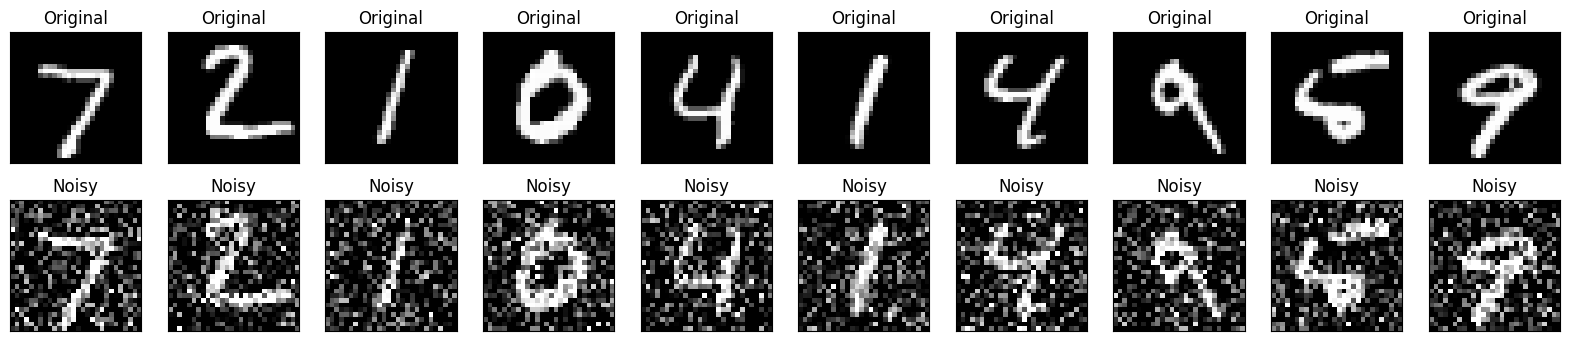

In [11]:
# Display sample images
def display_images(original, noisy, num=10):
    plt.figure(figsize=(20, 4))

    for i in range(num):
        # Original
        ax = plt.subplot(2, num, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Noisy
        ax = plt.subplot(2, num, i + 1 + num)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.savefig('original_vs_noisy.png')
    plt.show()

# Display the first 10 test images
display_images(x_test, x_test_noisy)

## 5. Build the Autoencoder Model

We'll use a convolutional autoencoder architecture with symmetric encoder and decoder.

In [5]:
# Input layer
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Model

In [6]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.2459 - val_loss: 0.1026
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1017 - val_loss: 0.0962
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0964 - val_loss: 0.0931
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0935 - val_loss: 0.0916
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0920 - val_loss: 0.0901
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0906 - val_loss: 0.0891
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0896 - val_loss: 0.0888
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0890 - val_loss: 0.0876
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0883 - val_loss: 0.0873
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0878 - val_loss: 0.0868
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0874 - val_loss: 0.0866
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/st

## 7. Plot Training History

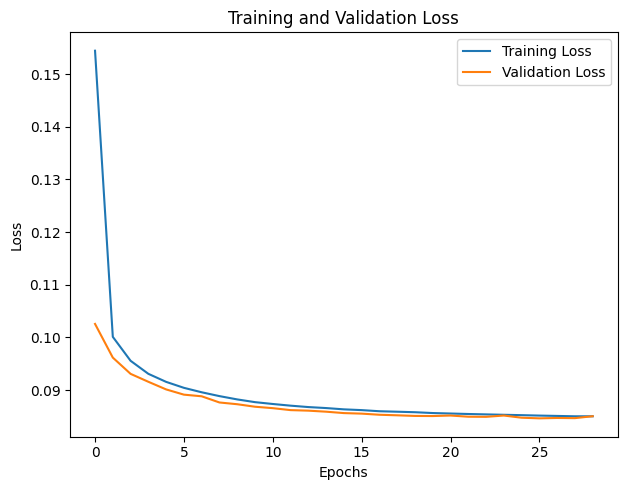

In [10]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_history.png')
    plt.tight_layout()
    plt.show()

plot_history(history)

## 8. Evaluate the Model

In [8]:
# Test the model on the test set
denoised_images = autoencoder.predict(x_test_noisy)

# Calculate PSNR (Peak Signal-to-Noise Ratio)
def psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Calculate average PSNR
avg_psnr = np.mean([psnr(x_test[i], denoised_images[i]) for i in range(len(x_test))])
print(f"Average PSNR: {avg_psnr:.2f} dB")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Average PSNR: 21.59 dB


In [13]:
import json
import os

# Create artifacts directory if it doesn't exist
os.makedirs("artifacts", exist_ok=True)

# ✅ Save the trained model
autoencoder.save("artifacts/autoencoder_model.h5")

# ✅ Save training history
history_dict = history.history  # history is the result of model.fit()
with open("artifacts/history.json", "w") as f:
    json.dump(history_dict, f)

print("Model and training history saved in artifacts/")


Model and training history saved in artifacts/


In [16]:
import numpy as np

# Example: x_train is your original image dataset, normalized to [0,1]
# You can use: (x_train, _), (_, _) = keras.datasets.mnist.load_data()
# and reshape/normalize it as needed

def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy = np.clip(noisy, 0., 1.)
    return noisy

# Assuming x_train is loaded and normalized
noisy_images = add_noise(x_train)

# Save to .npy
np.save("noisy_images.npy", noisy_images)

print("noisy_images.npy saved!")


noisy_images.npy saved!


## 9. Visualize Denoising Results

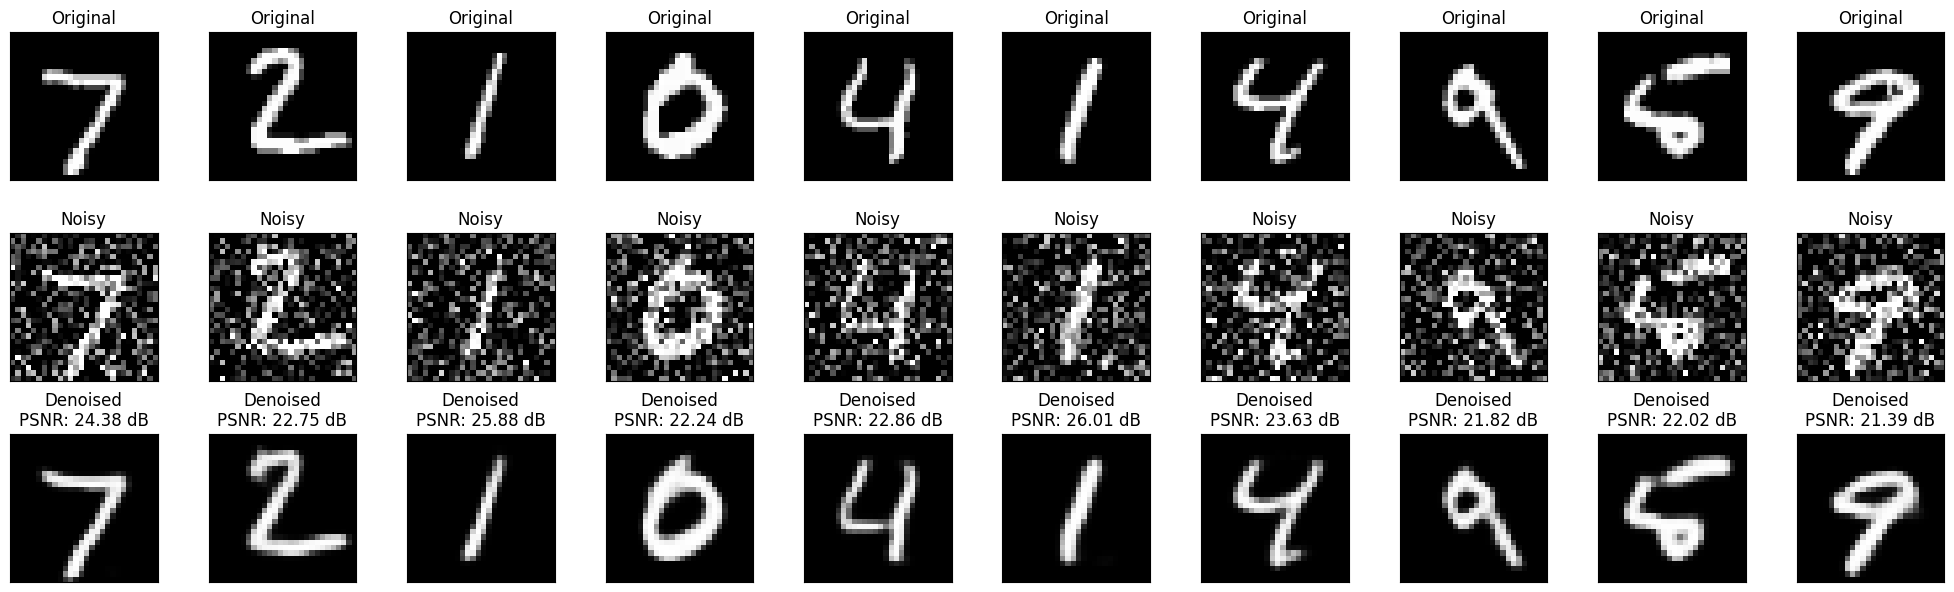

In [12]:
def display_results(original, noisy, denoised, num=10):
    plt.figure(figsize=(20, 6))

    for i in range(num):
        # Original
        ax = plt.subplot(3, num, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Noisy
        ax = plt.subplot(3, num, i + 1 + num)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Denoised
        ax = plt.subplot(3, num, i + 1 + 2*num)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        plt.title(f"Denoised\nPSNR: {psnr(original[i], denoised[i]):.2f} dB")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.savefig('denoised_images.png')
    plt.tight_layout()
    plt.show()

# Display results
display_results(x_test, x_test_noisy, denoised_images)

## 10. Conclusion and Next Steps

**Key Observations**:
- Autoencoders can effectively remove noise from images while preserving important features
- The convolutional architecture captures spatial patterns in images
- Higher PSNR values indicate better denoising performance

**Potential Improvements**:
1. Experiment with deeper architectures
2. Try different noise types (salt & pepper, speckle)
3. Use a different dataset (CIFAR-10, medical images)
4. Implement a variational autoencoder (VAE) for probabilistic denoising
5. Add skip connections (U-Net architecture)

**Real-world Applications**:
- Medical image denoising (X-rays, MRI scans)
- Astronomical image processing
- Old photo restoration
- Low-light image enhancement